In [ ]:
!pip install torch numpy transformers datasets tiktoken wandb tqdm pyphen -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 49.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 74.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 78.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 105.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rnd
import re
import pandas as pd
import pyphen
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

In [ ]:
rnd.seed(11111)

In [ ]:
nltk.download("punkt", quiet=True)

True

In [ ]:
def histplot(df: pd.DataFrame, bins=60, column=None, xlabel=None, ylabel="Frequency", title=None, saveas=None, saveonly=False, **plot_args):
    if column is None:
        column = df.columns[0]

    if xlabel is None:
        xlabel = column

    if title is None:
        title = f'Distribution of {column}'

    # Create a histogram to visualize the distribution of sentence lengths
    plt.hist(df[column], bins=np.arange(bins)-.5, **plot_args)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    if saveas is not None:
        plt.savefig(saveas)

    if not saveonly or saveas is None:
        plt.show()

## Importing data & nanoGPT repo

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = "/content/drive/MyDrive/Lab RU/NLP/Assignment 2 P3"

%cd $data_dir
!cp "nanoGPT/dante.txt" "."

/content/drive/MyDrive/Lab RU/NLP/Assignment 2 P3


## Counting syllables in original text

In [ ]:
def get_syllables(sent, lang):
    def foo(s):
        s = s.removesuffix("-").removeprefix("-")

        hyphens = re.findall("-", s)

        if len(hyphens) == 0:
            return [s]

        sections = s.split("-")
        if len(hyphens) > 1:
            return sections

        vowel_pat = re.compile("[AEIOUaeiou]")

        vow1 = vowel_pat.search(sections[0])
        vow2 = vowel_pat.search(sections[1])

        # If both halves contain vowels then it's a compound word
        if vow1 != None and vow2 != None:
            return sections

        return [s.replace("-", "")]

    dic = pyphen.Pyphen(lang=lang)

    syllables = dic.inserted(sent)

    syllables = [s for s in syllables.split(" ")]
    syllables = [s1 for s in syllables for s1 in foo(s)]

    return syllables

def count_syllables(sent, lang):
    return len(get_syllables(sent, lang))

# get_syllables('ed elli avea del cul fatto trombetta', lang='it_IT')
# count_syllables('ed elli avea del cul fatto trombetta', lang='it_IT')

In [ ]:
def get_syll_dataframe(lines, lang):
    if type(lines) is str:
        lines = lines.split("\n")

    data = pd.DataFrame([line.strip() for line in lines], columns=['text'])
    data["syl-count"] = data["text"].apply(lambda x: count_syllables(x, lang=lang))

    return data

def plot_syllcount(data, saveas):
    max_count = data["syl-count"].max()
    histplot(data, bins=max_count, column="syl-count",
            xlabel="Syllable Count", title="Syllable count distribution", saveas=saveas,
            edgecolor="black", linewidth=1.2, color="lightblue", range=[1,max_count])

In [ ]:
with open('dante.txt', 'r') as f:
    lines_original = f.readlines()

data = get_syll_dataframe(lines_original, lang="it_IT")
data.head()

,text,syl-count
0,Nel mezzo del cammin di nostra vita,12
1,mi ritrovai per una selva oscura,12
2,che' la diritta via era smarrita.,11
3,Ahi quanto a dir qual era e' cosa dura,13
4,esta selva selvaggia e aspra e forte,12


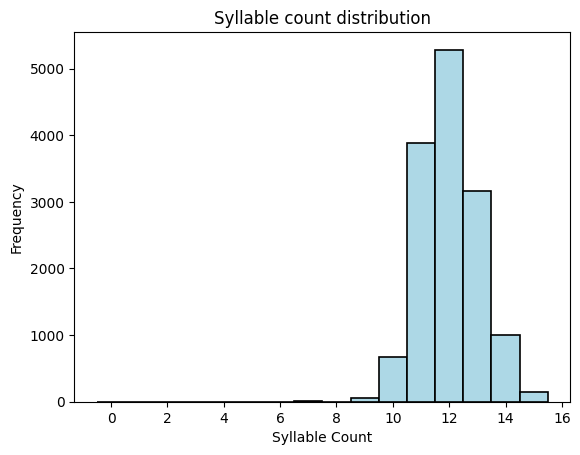

In [ ]:
plot_syllcount(data, "original.png")

## Experiment

### Helper functions

In [ ]:
def get_combined_range(values1, values2):
    return np.arange(min(np.min(values1), np.min(values2)),
                     max(np.max(values1), np.max(values2)) + 1)


def column_distribution(df, column_name, custom_range=None, zero_eps=1e-10):
    # Extract the values of column X from both DataFrames
    values = df[column_name].values

    if custom_range is None:
        custom_range = np.unique(df[column_name].values)

    distrib = np.histogram(values, bins=custom_range)[0] / len(values)

    return distrib + zero_eps

In [ ]:
def get_distributions(df1, df2, column):
    # Extract the values of column X from both DataFrames
    values_df1 = df1[column].values
    values_df2 = df2[column].values

    # Define the range based on all unique values in both DataFrames
    value_range = get_combined_range(values_df1, values_df2)

    # Calculate the probability distributions for each DataFrame over the defined range
    # Add a small epsilon value to avoid division by zero or taking the log of zero
    epsilon = 1e-10

    distribution_df1 = column_distribution(df1, column, custom_range = value_range, zero_eps = epsilon)
    distribution_df2 = column_distribution(df2, column, custom_range = value_range, zero_eps = epsilon)

    return distribution_df1, distribution_df2


In [ ]:
def calculate_cross_entropy(df1, df2, column_name):
    distribution_df1, distribution_df2 = get_distributions(df1, df2, column_name)

    # Ensure that the distributions have the same shape
    min_length = min(len(distribution_df1), len(distribution_df2))
    distribution_df1 = distribution_df1[:min_length]
    distribution_df2 = distribution_df2[:min_length]

    # Compute the cross-entropy
    cross_entropy = -np.sum(distribution_df1 * np.log(distribution_df2))

    return cross_entropy

In [ ]:
def calculate_jensen_shannon(df1, df2, column_name):
    distribution_df1, distribution_df2 = get_distributions(df1, df2, column_name)

    # Compute the average distribution
    average_distribution = 0.5 * (distribution_df1 + distribution_df2)

    # Calculate Jensen-Shannon Divergence for each distribution relative to the average distribution
    js_divergence_df1 = np.sum(distribution_df1 * np.log2(distribution_df1 / average_distribution))
    js_divergence_df2 = np.sum(distribution_df2 * np.log2(distribution_df2 / average_distribution))

    # Calculate the Jensen-Shannon Distance
    jensen_shannon_distance = np.sqrt(0.5 * (js_divergence_df1 + js_divergence_df2))

    return jensen_shannon_distance

In [ ]:
def text_to_vocab(text):
    tokens = word_tokenize(text)
    freq_dist = FreqDist(tokens)

    return list(freq_dist.keys())

In [ ]:
def sample_lines(text, count):
    l = len(text)
    lines = text.split("\n")

    if count < 0 or count > l:
        return []

    start = rnd.randint(l-count+1)

    return lines[start:start+count]

### Model setup & training

In [ ]:
params = [
    {
        "eval_iters": 20,
        "block_size": 64,
        "batch_size": 12,
        "n_layer": 4,
        "n_head": 4,
        "n_embd": 32, # * n_head => 128
        "lr_decay_iters": 2000,
        "dropout": 0.0,
        "max_iters": 2000,
    },
    {
        "n_layer": 4,
        "n_head": 4,
        "n_embd": 32, # * n_head => 128
        "block_size": 128,
        "max_iters": 4000,
    },
    {}, # n_embed = 384, block_size = 256, n_layer = n_head = 6
    {
        "n_layer": 12,
        "n_head": 12,
        "n_embd": 24, # * n_head => 768
        "block_size": 256,
    },
    {
        "n_layer": 12,
        "n_head": 12,
        "n_embd": 24, # * n_head => 768
        "block_size": 512,
        "max_iters": 6000,
    }
]

In [ ]:
import os

full_text = " ".join(lines_original)
full_vocab = text_to_vocab(full_text)

def params_to_str(params_dict: dict):
    return " ".join([f"--{key}={value}" for key, value in params_dict.items()])

def run_test(id=0, _params_dict={}, do_train=True, do_sample=True):
    print(f"=====================RUNNING TEST: {id}")

    params_dict = dict(_params_dict)

    params_dict.update({
        "log_interval": 10,
        #"device": "cpu",
        "compile": "False"
    })

    # Make sure the embedding size is a multiple of n_head
    if "n_embd" in params_dict.keys():
        n_head = params_dict.get("n_head", 6) # default n_head = 6
        params_dict["n_embd"] *= n_head

    print(f"Training overrides:")
    print(*[f"\t{key} = {value}" for key,value in params_dict.items()], sep="\n")
    print()

    train_args = params_to_str(params_dict)

    results_dir = f"tests/results/{id}"
    train_out = os.path.join(results_dir, f"train_output_{id}.txt")
    sample = os.path.join(results_dir, f"dante_gen_{id}.txt")
    sample_plot = os.path.join(results_dir, f"syllplot_{id}.png")
    stats = os.path.join(results_dir, f"stats_{id}.txt")

    print(f"Results dir: {results_dir}")
    print(f"Training output: {train_out}")
    print(f"Sample text: {sample}")
    print(f"Syl-count plot: {sample_plot}")
    print(f"Stats: {stats}")

    if do_train:
        print()
        print("TRAINING")
        print()

        #!mkdir -p ${tmp}
        !cd nanoGPT; python data/shakespeare_char/prepare.py
        print()

        tmp = os.path.join("..", train_out)
        !cd nanoGPT; python train.py config/train_shakespeare_char.py {train_args} | tee {tmp}
        print()

    if do_sample:
        print("SAMPLING")
        print()

        sampling_params = {
            #"device": "cpu",
            "out_dir": "out-shakespeare-char"
        }

        tmp = os.path.join("..", sample)
        tmp2 = params_to_str(sampling_params)
        !cd nanoGPT; python sample.py {tmp2} | tail -n +5 | sed '/^-*$/d' > {tmp}

    with open(sample, "r") as f:
        sample_lines = [line for line in f if line.strip()] # Non-blank lines

    lines_count = len(sample_lines)
    ref_lines = rnd.choice(lines_original, lines_count, replace=False)

    data_ref = get_syll_dataframe(ref_lines, lang="it_IT")
    data_gen = get_syll_dataframe(sample_lines, lang="it_IT")
    plot_syllcount(data_gen, saveas=sample_plot)

    ce = calculate_cross_entropy(data_ref, data_gen, "syl-count")
    js = calculate_jensen_shannon(data_ref, data_gen, "syl-count")

    sample_text = " ".join(sample_lines)
    sample_vocab = text_to_vocab(sample_text)

    tot = len(sample_vocab)
    existing = len([v for v in sample_vocab if v in full_vocab])

    train_loss = 0.
    val_loss = 0.

    with open(train_out, "r") as f:
        lines = f.readlines()
        target = "".join(lines[-5:])

        pattern = r"train loss (\d+\.\d+), val loss (\d+\.\d+)"

        pat_match = re.search(pattern, target)

        if pat_match:
            train_loss = float(pat_match.group(1))
            val_loss = float(pat_match.group(2))

    with open(stats, "w") as f:
        f.write(f"Train Loss: {train_loss}\n")
        f.write(f"Validation Loss: {val_loss}\n")

        f.write(f"Cross-Entropy: {ce:.3f}\n")
        f.write(f"Jensen-Shannon: {js*100.:.3f}%\n")

        f.write(f"% of sample words found in original vocabulary: {existing / tot*100.:.3f}%\n")

    print("FINAL STATS")
    !cat {stats}
    print()

=====================RUNNING TEST: 0
Training overrides:
	eval_iters = 20
	block_size = 64
	batch_size = 12
	n_layer = 4
	n_head = 4
	n_embd = 128
	lr_decay_iters = 2000
	dropout = 0.0
	max_iters = 2000
	log_interval = 10
	compile = False

Results dir: tests/results/0
Training output: tests/results/0/train_output_0.txt
Sample text: tests/results/0/dante_gen_0.txt
Syl-count plot: tests/results/0/syllplot_0.png
Stats: tests/results/0/stats_0.txt


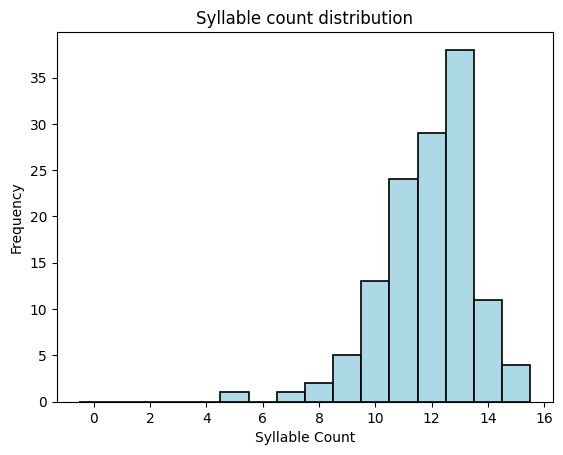

FINAL STATS
Train Loss: 1.7751
Validation Loss: 1.7753
Cross-Entropy: 1.647
Jensen-Shannon: 27.827%
% of sample words found in original vocabulary: 37.361%


=====================RUNNING TEST: 1
Training overrides:
	n_layer = 4
	n_head = 4
	n_embd = 128
	block_size = 128
	max_iters = 4000
	log_interval = 10
	compile = False

Results dir: tests/results/1
Training output: tests/results/1/train_output_1.txt
Sample text: tests/results/1/dante_gen_1.txt
Syl-count plot: tests/results/1/syllplot_1.png
Stats: tests/results/1/stats_1.txt


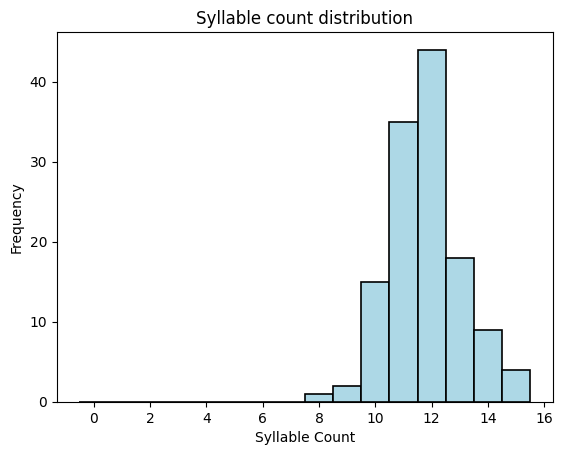

FINAL STATS
Train Loss: 1.4479
Validation Loss: 1.4821
Cross-Entropy: 1.546
Jensen-Shannon: 16.264%
% of sample words found in original vocabulary: 72.667%


=====================RUNNING TEST: 2
Training overrides:
	log_interval = 10
	compile = False

Results dir: tests/results/2
Training output: tests/results/2/train_output_2.txt
Sample text: tests/results/2/dante_gen_2.txt
Syl-count plot: tests/results/2/syllplot_2.png
Stats: tests/results/2/stats_2.txt


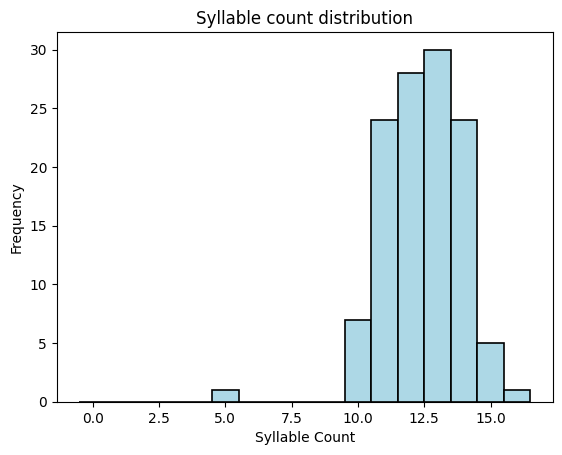

FINAL STATS
Train Loss: 0.1481
Validation Loss: 2.2943
Cross-Entropy: 1.975
Jensen-Shannon: 29.664%
% of sample words found in original vocabulary: 87.041%


=====================RUNNING TEST: 3
Training overrides:
	n_layer = 12
	n_head = 12
	n_embd = 288
	block_size = 256
	log_interval = 10
	compile = False

Results dir: tests/results/3
Training output: tests/results/3/train_output_3.txt
Sample text: tests/results/3/dante_gen_3.txt
Syl-count plot: tests/results/3/syllplot_3.png
Stats: tests/results/3/stats_3.txt


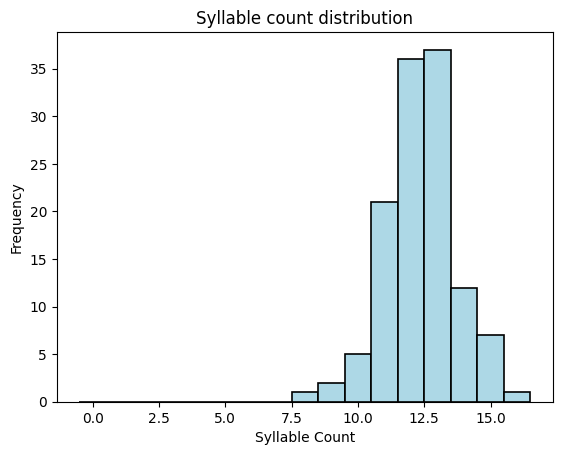

FINAL STATS
Train Loss: 0.1028
Validation Loss: 2.7737
Cross-Entropy: 1.542
Jensen-Shannon: 25.190%
% of sample words found in original vocabulary: 80.911%


=====================RUNNING TEST: 4
Training overrides:
	n_layer = 12
	n_head = 12
	n_embd = 288
	block_size = 512
	max_iters = 6000
	log_interval = 10
	compile = False

Results dir: tests/results/4
Training output: tests/results/4/train_output_4.txt
Sample text: tests/results/4/dante_gen_4.txt
Syl-count plot: tests/results/4/syllplot_4.png
Stats: tests/results/4/stats_4.txt


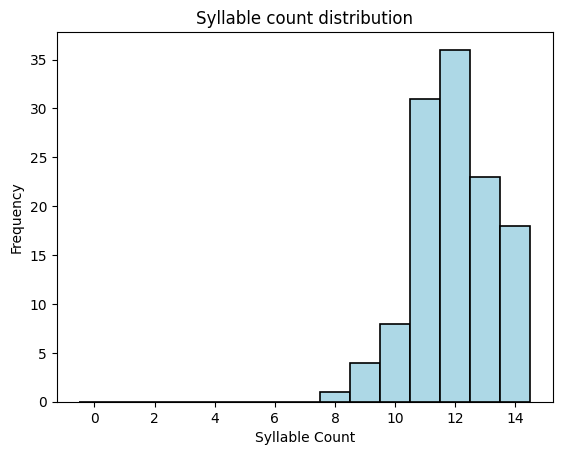

FINAL STATS
Train Loss: 0.0499
Validation Loss: 3.505
Cross-Entropy: 1.549
Jensen-Shannon: 19.159%
% of sample words found in original vocabulary: 78.889%




In [ ]:
for id, args in enumerate(params):
    run_test(id, args, do_train=False, do_sample=False)
    print()